In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np

import PIL
import PIL.Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
path_dataset = '/content/gdrive/MyDrive/ai-playground/ra-text-classification-spectrogram/images/isot-4000-bert'

In [4]:
dir_dataset = pathlib.Path(path_dataset)

In [5]:
newsTypes = ['fake', 'true']

totalImageCount = len(list(dir_dataset.glob('*/*.png')))
print('Total news spectrograms count: ' + str(totalImageCount))

for newsType in newsTypes:
  print ('Number of news spectrograms of type ' + newsType + ' = ' + str(len(list(dir_dataset.glob(newsType + '/*.png')))))

Total news spectrograms count: 2332
Number of news spectrograms of type fake = 1113
Number of news spectrograms of type true = 1219


Sample true news spectrogram


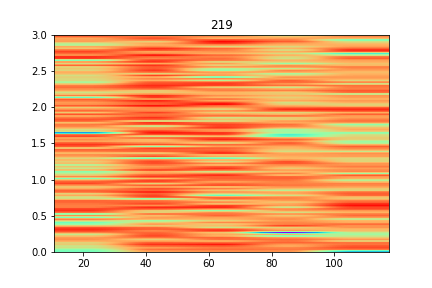

In [6]:
print ('Sample true news spectrogram')
PIL.Image.open(str(list(dir_dataset.glob('true/*'))[0]))

Sample fake news spectrogram


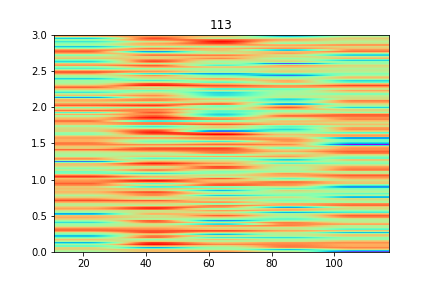

In [7]:
print ('Sample fake news spectrogram')
PIL.Image.open(str(list(dir_dataset.glob('fake/*'))[0]))

In [8]:
import tensorflow as tf

# Create a training and validation dataset

TRAIN_FRACTION = 0.8
batch_size = 32 # default batch size of data
img_height = 180 # default height to which image is resized
img_width = 180 # default width to which image is resized
seed = 123 # random seed for shuffling and transformations

# Training dataset
ds_train = tf.keras.utils.image_dataset_from_directory(
  dir_dataset,
  validation_split = 1 - TRAIN_FRACTION,
  subset = "training",
  seed = seed,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 2332 files belonging to 2 classes.
Using 1866 files for training.


In [9]:
# Validation dataset
ds_val = tf.keras.utils.image_dataset_from_directory(
  dir_dataset,
  validation_split = 1 - TRAIN_FRACTION,
  subset = "validation",
  seed = seed,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 2332 files belonging to 2 classes.
Using 466 files for validation.


In [10]:
class_names = ds_train.class_names
print(class_names)

['fake', 'true']


In [11]:
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# Standardise the RGB channel values from [0, 255] to [0, 1] range
# for efficient training of the neural network model
normalization_layer = tf.keras.layers.Rescaling(1./255)

ds_normalised = ds_train.map(lambda x, y: (normalization_layer(x), y))

# Confirm that rescaling completed
image_batch, labels_batch = next(iter(ds_normalised))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.009020159 1.0


In [14]:
num_classes = 2

# Build a Sequential model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
# Optimise the model
model.compile(
  optimizer = 'adam',
  loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [17]:
# Train the model for 10 epochs
epochs = 30

history = model.fit(
  ds_train,
  validation_data = ds_val,
  epochs = epochs
)

Epoch 1/30
59/59 [==============================] - 123s 2s/step - loss: 0.8763 - accuracy: 0.5563 - val_loss: 0.6157 - val_accuracy: 0.7124
Epoch 2/30
59/59 [==============================] - 68s 1s/step - loss: 0.4630 - accuracy: 0.7953 - val_loss: 0.3495 - val_accuracy: 0.8519
Epoch 3/30
59/59 [==============================] - 68s 1s/step - loss: 0.2774 - accuracy: 0.8901 - val_loss: 0.2331 - val_accuracy: 0.9013
Epoch 4/30
59/59 [==============================] - 68s 1s/step - loss: 0.2166 - accuracy: 0.9218 - val_loss: 0.2031 - val_accuracy: 0.9206
Epoch 5/30
59/59 [==============================] - 68s 1s/step - loss: 0.1834 - accuracy: 0.9271 - val_loss: 0.2874 - val_accuracy: 0.8906
Epoch 6/30
59/59 [==============================] - 69s 1s/step - loss: 0.1821 - accuracy: 0.9346 - val_loss: 0.1784 - val_accuracy: 0.9206
Epoch 7/30
59/59 [==============================] - 68s 1s/step - loss: 0.1508 - accuracy: 0.9373 - val_loss: 0.1602 - val_accuracy: 0.9335
Epoch 8/30
59/59 [=

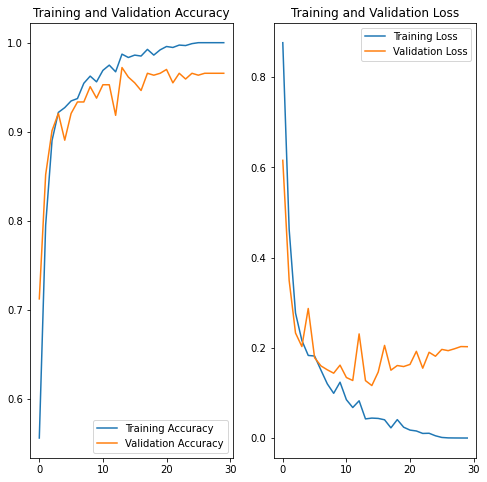

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()